# Calculate eof of along-slope velocity transformed into ASC coordinate system 

This scripts calculates eof of daily along-slope velocity data that were transformed into an ASC coordinate system. The transformation is done in `Calc_ASCcoord_transform_ocean.ipynb`.

We use the ASC regimes as defined in `xyz.ipynb` to highlight different regions.

In [4]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import matplotlib.gridspec as gridspec
from eofs.xarray import Eof

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [5]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34353/status,
Dashboard: /proxy/34353/status,Workers: 4
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40763,Workers: 4
Dashboard: /proxy/34353/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://10.0.128.131:46451,Total threads: 2
Dashboard: /proxy/34539/status,Memory: 5.62 GiB
Nanny: tcp://127.0.0.1:40723,


### Load in pre-calculated velocity data

In [6]:
file_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'transects_binned_daily_full_dropna.nc'

ds = xr.open_dataarray(file_path + file_name)

In [4]:
ds

<xarray.DataArray 'u_along_binned' (lon_shelf: 3264, time: 365, st_ocean: 54, depth_bin: 27)>
[1737002880 values with dtype=float64]
Coordinates:
  * time       (time) object 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
  * lon_shelf  (lon_shelf) float64 -279.9 -279.8 -279.6 ... 79.7 79.8 79.9
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
  * depth_bin  (depth_bin) float64 630.7 663.1 695.4 ... 1.933e+03 2.007e+03
Attributes:
    description:  along-slope velocity
    units:        m/s

### ASC regime information

First, remove lon/lat values from 630-m isobath that got removed as some transects had bumps.

In [7]:
in_file  = '/g/data/x77/wgh581/Post_Process/' + 'Antarctic_slope_transects_630m_2000m.npz'
in_data  = np.load(in_file)
lon_630m = in_data['lon_630m']
lat_630m = in_data['lat_630m']

In [8]:
index_nan = []
lon_shelf_nan = ds.lon_shelf.values
for ii in range(len(lon_630m)):
    if (lon_630m[ii] - lon_shelf_nan[ii]) != 0:
        lon_shelf_nan = np.insert(lon_shelf_nan, ii, lon_630m[ii])
        index_nan.append(ii)
index_nan = index_nan[::-1]

In [9]:
lon_630m_dropna = lon_630m.tolist()
lat_630m_dropna = lat_630m.tolist()
for ii in range(len(index_nan)):
    del lon_630m_dropna[index_nan[ii]]
    del lat_630m_dropna[index_nan[ii]]

Distance along the 1-km isobath

In [10]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [11]:
distance_along_contour = np.zeros((len(ds.lon_shelf)))
for ii in range(len(ds.lon_shelf)-1):
    lat1 = lat_630m_dropna[ii]
    lat2 = lat_630m_dropna[ii+1]
    lon1 = lon_630m_dropna[ii]
    lon2 = lon_630m_dropna[ii+1]
    distance_along_contour[ii+1] = gcdist(lat1, lat2, lon1, lon2)
distance_along_contour_cumsum = distance_along_contour.cumsum()

ASC regimes

In [12]:
# Load ASC classification (calculated in Calc_ASC_classification.ipynb)
file_path   = '/g/data/x77/wgh581/Post_Process/'
file_name   = 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes = np.load(file_path + file_name)
ASC_regimes = ASC_regimes['ASC_regimes_annual']

In [13]:
# Load lon/lat on 1km isobath, u-grid
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'
data = np.load(file_path + file_name)
#data.files
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']

In [14]:
# Indeces with ASC regime information
var = np.diff(ASC_regimes)
index_tmp = [0]
ASC_tmp   = []
lon_test  = []
lat_test  = []
for ii in range(len(var)):
    if var[ii] != 0:
        lon_tmp = lon_along_contour[ii]
        lat_tmp = lat_along_contour[ii]
        index_tmp.append( np.argmin((lon_630m_dropna - lon_tmp)**2 + (lat_630m_dropna - lat_tmp)**2) )
        ASC_tmp.append(ASC_regimes[ii-1])
        lon_test.append(lon_tmp)
        lat_test.append(lat_tmp)
ASC_tmp.append(0)
index_tmp.append(len(ds.lon_shelf.values))

In [71]:
index_tmp[7] = 1960
index_tmp[8] = 1960

In [15]:
# Variable with regime info (one of: 0, 1, 2)
ASC_regimes_binned =  np.zeros(len(ds.lon_shelf)) * np.nan
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        # Surface-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 0
    elif ASC_tmp[ii] == 1:
        # Bottom-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 1
    elif ASC_tmp[ii] == 2:
        # Reversed ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 2
ASC_regimes_binned_2d = np.vstack((ASC_regimes_binned, ASC_regimes_binned))

### Plotting information

In [16]:
# Costum colormap
import matplotlib
colorsList_no3 = [('lightgreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

### EOF for each transect

In [17]:
n_eof = 3

In [18]:
def get_eof(data, n_eof=3):
    """
    n_eof: Number of eofs to calculate
    """
    # Solver
    solver_tmp = Eof(data)
    # Total variance
    total_variance_tmp = solver_tmp.totalAnomalyVariance()
    # EOFs
    eofs_tmp = solver_tmp.eofs(neofs=n_eof)
    # Variance fraction (of total)
    variance_tmp = solver_tmp.varianceFraction(neigs=n_eof)
    # Principal Component time series 
    # -> scaled to unit variance (divided by the square-root of their eigenvalue)
    pcs_tmp = solver_tmp.pcs(npcs=3, pcscaling=1)
    
    return eofs_tmp, variance_tmp, total_variance_tmp, pcs_tmp

#### 1. Full transects

In [6]:
# Initialise numpy arrays with correct dimensions
eof_field_np          = np.zeros((len(ds.lon_shelf), n_eof, len(ds.st_ocean), len(ds.depth_bin)))
variance_fractions_np = np.zeros((len(ds.lon_shelf), n_eof))
total_variance_np     = np.zeros(len(ds.lon_shelf))
pcs_np                = np.zeros((len(ds.lon_shelf), len(ds.time), n_eof))

In [7]:
# Run eof for each transect
for ii in range(len(ds.lon_shelf)):
    if ii >=0:
        eof_field_np[ii,:,:,:], variance_fractions_np[ii,:], total_variance_np[ii], pcs_np[ii,:,:] = get_eof(ds[ii,:,:,:])

In [8]:
# Write numpy arrays as xarray.DataArray
eof_field = xr.DataArray(data=eof_field_np, dims=["lon_shelf", "mode", "st_ocean", "depth_bin"], \
                  coords=dict(lon_shelf=ds.lon_shelf, mode=[0,1,2], st_ocean=ds.st_ocean, depth_bin=ds.depth_bin)).rename('eofs')
variance_fractions = xr.DataArray(data=variance_fractions_np, dims=["lon_shelf", "mode"], \
                  coords=dict(lon_shelf=ds.lon_shelf, mode=[0,1,2])).rename('variance_fractions')
total_variance = xr.DataArray(data=total_variance_np, dims=["lon_shelf"], \
                  coords=dict(lon_shelf=ds.lon_shelf)).rename('total_variance')
pcs = xr.DataArray(data=pcs_np, dims=["lon_shelf", "time", "mode"], \
                  coords=dict(lon_shelf=ds.lon_shelf, time=ds.time, mode=[0,1,2])).rename('pcs')

In [9]:
# Check if there are zero crossing (0=barotropic, 1=baroclinic)
mode_0 = np.zeros(len(ds.lon_shelf))
mode_1 = np.zeros(len(ds.lon_shelf))
mode_2 = np.zeros(len(ds.lon_shelf))for

# mode 0:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field[ii,0,:,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_0[ii] = 1
            #print(ii)
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_0[ii] = 1

# mode 1:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field[ii,1,:,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_1[ii] = 1
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_1[ii] = 1
            
# mode 2:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field[ii,2,:,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_2[ii] = 1
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_2[ii] = 1

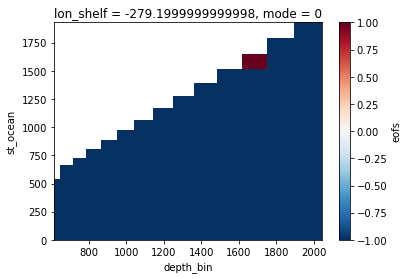

In [235]:
sign_tmp = np.sign(eof_field[5,0,:,:])
sign_tmp.plot()

#### 2. Cross-slope averages

In [19]:
# Initialise numpy arrays with correct dimensions
eof_field_np_cs          = np.zeros((len(ds.lon_shelf), n_eof, len(ds.st_ocean)))
variance_fractions_np_cs = np.zeros((len(ds.lon_shelf), n_eof))
total_variance_np_cs     = np.zeros(len(ds.lon_shelf))
pcs_np_cs                = np.zeros((len(ds.lon_shelf), len(ds.time), n_eof))

In [20]:
# Run eof for each transect
for ii in range(len(ds.lon_shelf)):
    if ii < 300:
        eof_field_np_cs[ii,:,:], variance_fractions_np_cs[ii,:], total_variance_np_cs[ii], pcs_np_cs[ii,:,:] = get_eof(ds[ii,:,:,:].mean('depth_bin'))

In [21]:
# Write numpy arrays as xarray.DataArray
eof_field_cs = xr.DataArray(data=eof_field_np_cs, dims=["lon_shelf", "mode", "st_ocean"], \
                  coords=dict(lon_shelf=ds.lon_shelf, mode=[0,1,2], st_ocean=ds.st_ocean)).rename('eofs')
variance_fractions_cs = xr.DataArray(data=variance_fractions_np_cs, dims=["lon_shelf", "mode"], \
                  coords=dict(lon_shelf=ds.lon_shelf, mode=[0,1,2])).rename('variance_fractions')
total_variance_cs = xr.DataArray(data=total_variance_np_cs, dims=["lon_shelf"], \
                  coords=dict(lon_shelf=ds.lon_shelf)).rename('total_variance')
pcs_cs = xr.DataArray(data=pcs_np_cs, dims=["lon_shelf", "time", "mode"], \
                  coords=dict(lon_shelf=ds.lon_shelf, time=ds.time, mode=[0,1,2])).rename('pcs')

In [22]:
# Check if there are zero crossing (0=barotropic, 1=baroclinic)
mode_0_cs = np.zeros(len(ds.lon_shelf))
mode_1_cs = np.zeros(len(ds.lon_shelf))
mode_2_cs = np.zeros(len(ds.lon_shelf))

# mode 0:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field_cs[ii,0,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_0_cs[ii] = 1
            #print(ii)
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_0_cs[ii] = 1

# mode 1:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field_cs[ii,1,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_1_cs[ii] = 1
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_1_cs[ii] = 1
            
# mode 2:
for ii in range(len(ds.lon_shelf)):
    sign_tmp = np.sign(eof_field_cs[ii,2,:])

    if (sign_tmp==-1).any():
        if (sign_tmp==1).any():
            # baroclinic
            mode_2_cs[ii] = 1
    if (sign_tmp==1).any():
        if (sign_tmp==-1).any():
            # baroclinic
            mode_2_cs[ii] = 1

### Regime averages

Finally calculate regime averages

In [91]:
# Total explained variance, full field
total_variance_0 = np.where(ASC_regimes_binned==0, total_variance, np.nan)
total_variance_0 = np.nanmean(total_variance_0, axis=0)

total_variance_1 = np.where(ASC_regimes_binned==1, total_variance, np.nan)
total_variance_1 = np.nanmean(total_variance_1, axis=0)

total_variance_2 = np.where(ASC_regimes_binned==2, total_variance, np.nan)
total_variance_2 = np.nanmean(total_variance_2, axis=0)

# Total explained variance, cross-slope average
total_variance_cs_0 = np.where(ASC_regimes_binned==0, total_variance_cs, np.nan)
total_variance_cs_0 = np.nanmean(total_variance_cs_0, axis=0)

total_variance_cs_1 = np.where(ASC_regimes_binned==1, total_variance_cs, np.nan)
total_variance_cs_1 = np.nanmean(total_variance_cs_1, axis=0)

total_variance_cs_2 = np.where(ASC_regimes_binned==2, total_variance_cs, np.nan)
total_variance_cs_2 = np.nanmean(total_variance_cs_2, axis=0)

In [95]:
print('Total variance (cross-slope average / full field)')
print('Surface-intensified: ', np.round(total_variance_cs_0, 2), '/', np.round(total_variance_0, 2))
print('Bottom-intensified: ', np.round(total_variance_cs_1, 2), '/', np.round(total_variance_1, 2))
print('Reversed: ', np.round(total_variance_cs_2, 2), '/', np.round(total_variance_2, 2))

Total variance (cross-slope average / full field)
Surface-intensified:  0.21 / 6.91
Bottom-intensified:  0.09 / 3.02
Reversed:  0.1 / 2.95


In [178]:
# Explained variance
# Mode 0:
var_frac_mode0_0 = np.where(ASC_regimes_binned==0, variance_fractions[:,0], np.nan)
var_frac_mode0_0 = np.nanmean(var_frac_mode0_0, axis=0)
var_frac_mode0_1 = np.where(ASC_regimes_binned==1, variance_fractions[:,0], np.nan)
var_frac_mode0_1 = np.nanmean(var_frac_mode0_1, axis=0)
var_frac_mode0_2 = np.where(ASC_regimes_binned==2, variance_fractions[:,0], np.nan)
var_frac_mode0_2 = np.nanmean(var_frac_mode0_2, axis=0)
# Mode 1:
var_frac_mode1_0 = np.where(ASC_regimes_binned==0, variance_fractions[:,1], np.nan)
var_frac_mode1_0 = np.nanmean(var_frac_mode1_0, axis=0)
var_frac_mode1_1 = np.where(ASC_regimes_binned==1, variance_fractions[:,1], np.nan)
var_frac_mode1_1 = np.nanmean(var_frac_mode1_1, axis=0)
var_frac_mode1_2 = np.where(ASC_regimes_binned==2, variance_fractions[:,1], np.nan)
var_frac_mode1_2 = np.nanmean(var_frac_mode1_2, axis=0)
# Mode 2:
var_frac_mode2_0 = np.where(ASC_regimes_binned==0, variance_fractions[:,2], np.nan)
var_frac_mode2_0 = np.nanmean(var_frac_mode2_0, axis=0)
var_frac_mode2_1 = np.where(ASC_regimes_binned==1, variance_fractions[:,2], np.nan)
var_frac_mode2_1 = np.nanmean(var_frac_mode2_1, axis=0)
var_frac_mode2_2 = np.where(ASC_regimes_binned==2, variance_fractions[:,2], np.nan)
var_frac_mode2_2 = np.nanmean(var_frac_mode2_2, axis=0)

# Mode 0:
var_frac_mode0_cs_0 = np.where(ASC_regimes_binned==0, variance_fractions_cs[:,0], np.nan)
var_frac_mode0_cs_0 = np.nanmean(var_frac_mode0_cs_0, axis=0)
var_frac_mode0_cs_1 = np.where(ASC_regimes_binned==1, variance_fractions_cs[:,0], np.nan)
var_frac_mode0_cs_1 = np.nanmean(var_frac_mode0_cs_1, axis=0)
var_frac_mode0_cs_2 = np.where(ASC_regimes_binned==2, variance_fractions_cs[:,0], np.nan)
var_frac_mode0_cs_2 = np.nanmean(var_frac_mode0_cs_2, axis=0)
# Mode 1:
var_frac_mode1_cs_0 = np.where(ASC_regimes_binned==0, variance_fractions_cs[:,1], np.nan)
var_frac_mode1_cs_0 = np.nanmean(var_frac_mode1_cs_0, axis=0)
var_frac_mode1_cs_1 = np.where(ASC_regimes_binned==1, variance_fractions_cs[:,1], np.nan)
var_frac_mode1_cs_1 = np.nanmean(var_frac_mode1_cs_1, axis=0)
var_frac_mode1_cs_2 = np.where(ASC_regimes_binned==2, variance_fractions_cs[:,1], np.nan)
var_frac_mode1_cs_2 = np.nanmean(var_frac_mode1_cs_2, axis=0)
# Mode 2:
var_frac_mode2_cs_0 = np.where(ASC_regimes_binned==0, variance_fractions_cs[:,2], np.nan)
var_frac_mode2_cs_0 = np.nanmean(var_frac_mode2_cs_0, axis=0)
var_frac_mode2_cs_1 = np.where(ASC_regimes_binned==1, variance_fractions_cs[:,2], np.nan)
var_frac_mode2_cs_1 = np.nanmean(var_frac_mode2_cs_1, axis=0)
var_frac_mode2_cs_2 = np.where(ASC_regimes_binned==2, variance_fractions_cs[:,2], np.nan)
var_frac_mode2_cs_2 = np.nanmean(var_frac_mode2_cs_2, axis=0)

In [ ]:
#result = np.repeat(ASC_regimes_binned[np.newaxis,...], 183, axis=0).transpose()

### Plotting

#### Total variance

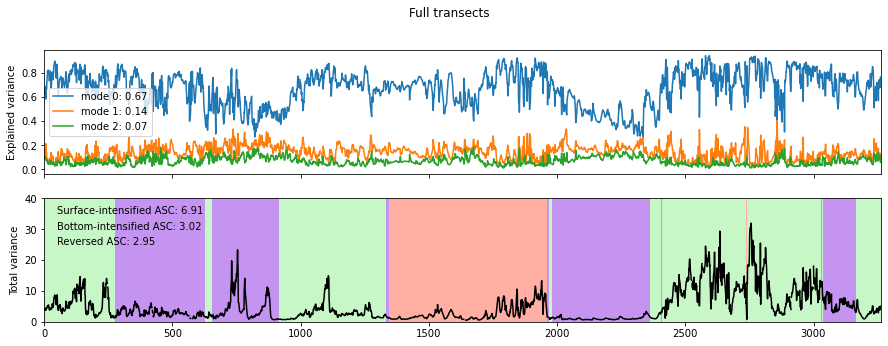

In [163]:
fig = plt.figure(figsize=(15,5))

plt.suptitle('Full transects', y=1.0)
label_name = ['mode 0: %.2f'%np.mean(variance_fractions[:,0]), 'mode 1: %.2f'%np.mean(variance_fractions[:,1]), 'mode 2: %.2f'%np.mean(variance_fractions[:,2])]

plt.subplot(211)
for ii in range(n_eof):
    plt.plot(variance_fractions[:,ii], label=label_name[ii])
plt.legend()
plt.ylabel('Explained variance')
plt.xlim(0, len(ds.lon_shelf))
# : %.2f'%np.round(total_variance_0, 2)
plt.tick_params(labelbottom=False)

plt.subplot(212)
total_variance[total_variance > 100] = np.nan # Overwriting an outlier
plt.plot(total_variance, color='k')
plt.ylabel('Total variance')
plt.ylim(0, 40)
plt.xlim(0, len(ds.lon_shelf))
plt.pcolormesh(np.arange(0, len(ds.lon_shelf), 1), np.arange(0, 60, 20), ASC_regimes_binned_2d, alpha=0.5, cmap=CustomCmap_no3)
plt.text(50, 35, 'Surface-intensified ASC: %.2f'%np.round(total_variance_0, 2));
plt.text(50, 30, 'Bottom-intensified ASC: %.2f'%np.round(total_variance_1, 2));
plt.text(50, 25, 'Reversed ASC: %.2f'%np.round(total_variance_2, 2));

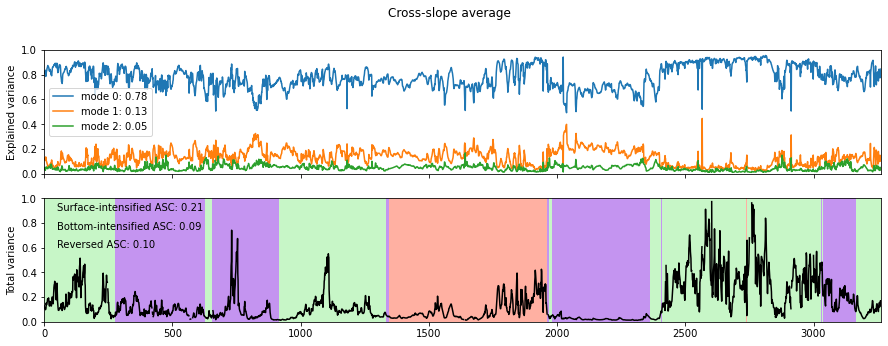

In [165]:
fig = plt.figure(figsize=(15,5))

plt.suptitle('Cross-slope average', y=1.0)
label_name_cs = ['mode 0: %.2f'%np.mean(variance_fractions_cs[:,0]), 'mode 1: %.2f'%np.mean(variance_fractions_cs[:,1]), 'mode 2: %.2f'%np.mean(variance_fractions_cs[:,2])]

plt.subplot(211)
for ii in range(n_eof):
    plt.plot(variance_fractions_cs[:,ii], label=label_name_cs[ii])
plt.legend()
plt.ylabel('Explained variance')
plt.ylim(0, 1)
plt.xlim(0, len(ds.lon_shelf))
plt.tick_params(labelbottom=False)

plt.subplot(212)
total_variance_cs[total_variance_cs > 1] = np.nan # Overwriting an outlier
plt.plot(total_variance_cs, color='k')
plt.ylabel('Total variance')
plt.ylim(0, 1)
plt.xlim(0, len(ds.lon_shelf))
plt.pcolormesh(np.arange(0, len(ds.lon_shelf), 1), np.arange(0, 1.5, 0.5), ASC_regimes_binned_2d, alpha=0.5, cmap=CustomCmap_no3)
plt.text(50, 0.9, 'Surface-intensified ASC: %.2f'%np.round(total_variance_cs_0, 2));
plt.text(50, 0.75, 'Bottom-intensified ASC: %.2f'%np.round(total_variance_cs_1, 2));
plt.text(50, 0.6, 'Reversed ASC: %.2f'%np.round(total_variance_cs_2, 2));

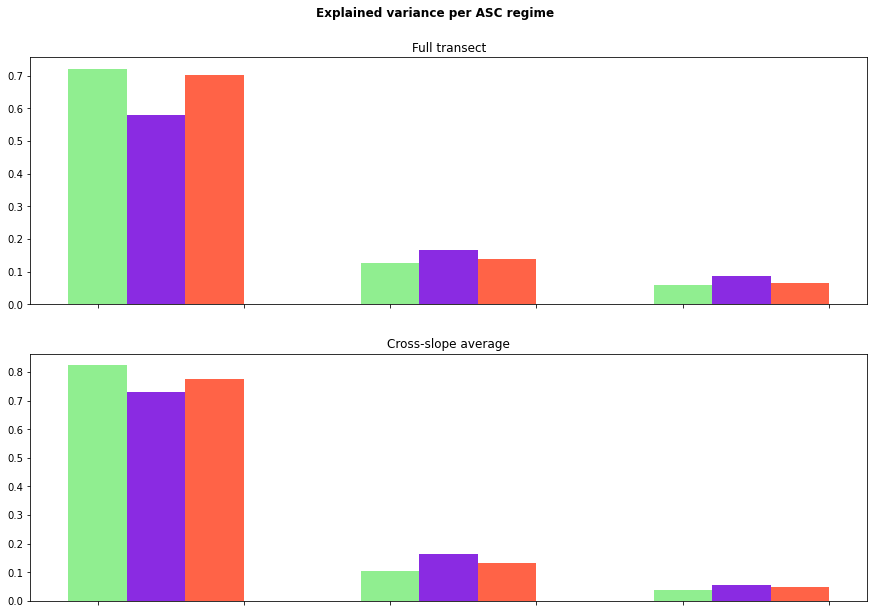

In [206]:
fig = plt.figure(figsize=(15,10))
plt.suptitle('Explained variance per ASC regime', y=0.95, fontweight='bold')

plt.subplot(2, 1, 1)
plt.title('Full transect')
data0 = [var_frac_mode0_0, var_frac_mode1_0, var_frac_mode2_0]
data1 = [var_frac_mode0_1, var_frac_mode1_1, var_frac_mode2_1]
data2 = [var_frac_mode0_2, var_frac_mode1_2, var_frac_mode2_2]
width=0.2
plt.bar(np.arange(len(data0)), data0, width=width, color='lightgreen')
plt.bar(np.arange(len(data0))+width, data1, width=width, color='blueviolet')
plt.bar(np.arange(len(data0))+(2*width), data2, width=width, color='tomato')
plt.tick_params(labelbottom=False)
#plt.bar([0.5, 1.5, 2.5], [np.round(var_frac_mode0_0, 2), np.round(var_frac_mode0_1, 2), np.round(var_frac_mode0_2, 2)], cmap=CustomCmap_no3)
#[('lightgreen'),('blueviolet'),('tomato')]

plt.subplot(2, 1, 2)
plt.title('Cross-slope average')
data0_cs = [var_frac_mode0_cs_0, var_frac_mode1_cs_0, var_frac_mode2_cs_0]
data1_cs = [var_frac_mode0_cs_1, var_frac_mode1_cs_1, var_frac_mode2_cs_1]
data2_cs = [var_frac_mode0_cs_2, var_frac_mode1_cs_2, var_frac_mode2_cs_2]
width=0.2
plt.bar(np.arange(len(data0)), data0_cs, width=width, color='lightgreen')
plt.bar(np.arange(len(data0))+width, data1_cs, width=width, color='blueviolet')
plt.bar(np.arange(len(data0))+(2*width), data2_cs, width=width, color='tomato')
plt.tick_params(labelbottom=False)

In [209]:
print('Full profiles')
print(np.round(data0,2))
print(np.round(data1,2))
print(np.round(data2,2))

print('Cross-slope averages')
print(np.round(data0_cs,2))
print(np.round(data1_cs,2))
print(np.round(data2_cs,2))

Full profiles
[0.72 0.13 0.06]
[0.58 0.17 0.09]
[0.7  0.14 0.06]
Cross-slope averages
[0.82 0.1  0.04]
[0.73 0.16 0.05]
[0.78 0.13 0.05]


In [133]:
def plot_eof(nn=0):
    """
    nn: transect number to plot
    """

    # Plotting
    fig = plt.figure(figsize=(15,10))
    plt.suptitle('Transect %i'%nn, fontweight='bold')
    for ii in range(n_eof):

        plt.subplot(2, 3, ii+1)
        plt.pcolormesh(eof_field.depth_bin, eof_field.st_ocean, eof_field[nn,ii,:,:], cmap='RdBu', vmin=-0.01, vmax=0.01)
        plt.colorbar()
        plt.ylim(2000, 0)
        plt.title(r'Mode %i, %i'%(ii,np.round(variance_fractions[nn,ii].values,2)*100) + '%')
        if ii > 0:
            plt.tick_params(labelleft=False)
        plt.ylabel('Depth (m)')

        plt.subplot(2, 3, ii+4)
        plt.plot(eof_field_cs[nn,ii,:], eof_field_cs.st_ocean)#, cmap='RdBu', vmin=-0.01, vmax=0.01)
        plt.ylim(2000, 0)
        plt.axvline(0, color='k')
        plt.title(r'Mode %i, %i'%(ii,np.round(variance_fractions_cs[nn,ii].values,2)*100) + '%')
        plt.ylabel('Depth (m)')

In [25]:
def plot_eof_cs(nn=0):
    """
    nn: transect number to plot
    """

    # Plotting
    fig = plt.figure(figsize=(15,5))
    plt.suptitle('Transect %i'%nn, fontweight='bold', y=1.0)
    for ii in range(n_eof):

        plt.subplot(1, 3, ii+1)
        plt.plot(eof_field_cs[nn,ii,:], eof_field_cs.st_ocean)#, cmap='RdBu', vmin=-0.01, vmax=0.01)
        plt.ylim(2000, 0)
        plt.axvline(0, color='k')
        plt.title(r'Mode %i, %i'%(ii,np.round(variance_fractions_cs[nn,ii].values,2)*100) + '%')

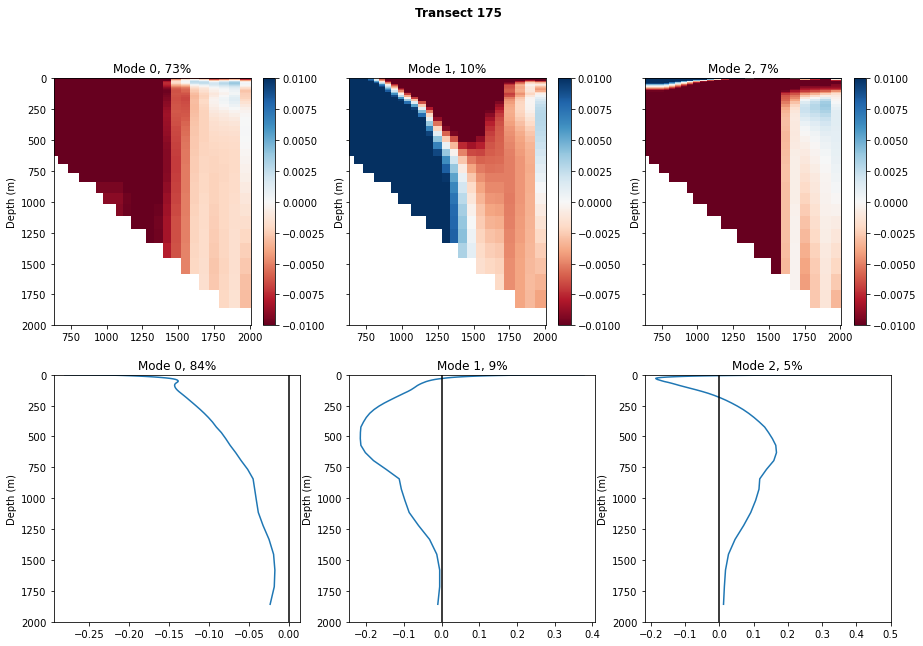

In [134]:
plot_eof(nn=175)

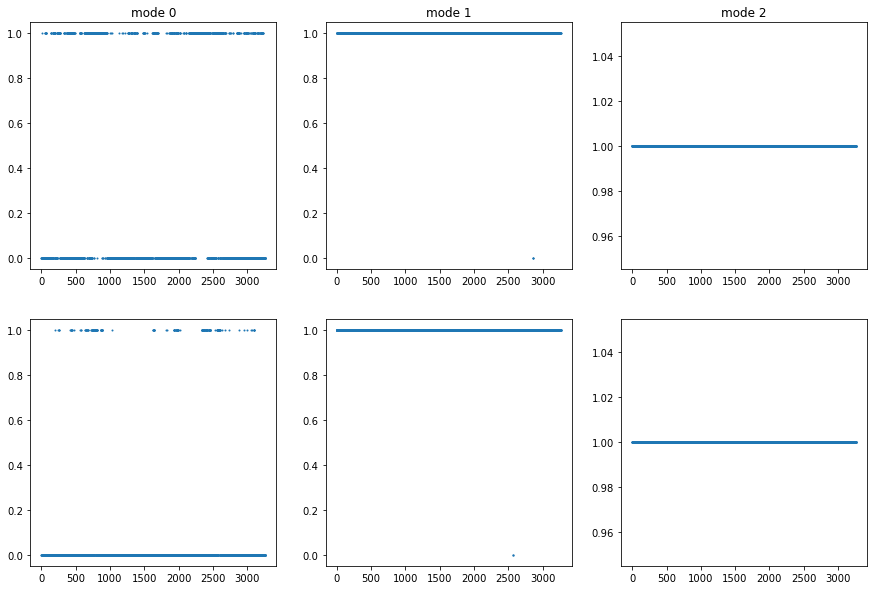

In [138]:
fig = plt.figure(figsize=(15,10))

plt.subplot(231)
plt.title('mode 0')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_0, s=1)

plt.subplot(232)
plt.title('mode 1')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_1, s=1)

plt.subplot(233)
plt.title('mode 2')
plt.plot(mode_2, label='0: barotropic, 1: baroclinic')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_2, s=1) 

plt.subplot(234)
#plt.title('0: barotropic, 1: baroclinic', loc='left')
#plt.title('mode 0')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_0_cs, s=1)

plt.subplot(235)
#plt.title('mode 1')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_1_cs, s=2)

plt.subplot(236)
#plt.title('mode 2')
plt.scatter(np.arange(0, len(ds.lon_shelf), 1), mode_2_cs, s=1, label='0: barotropic, 1: baroclinic');
#plt.legend();

---

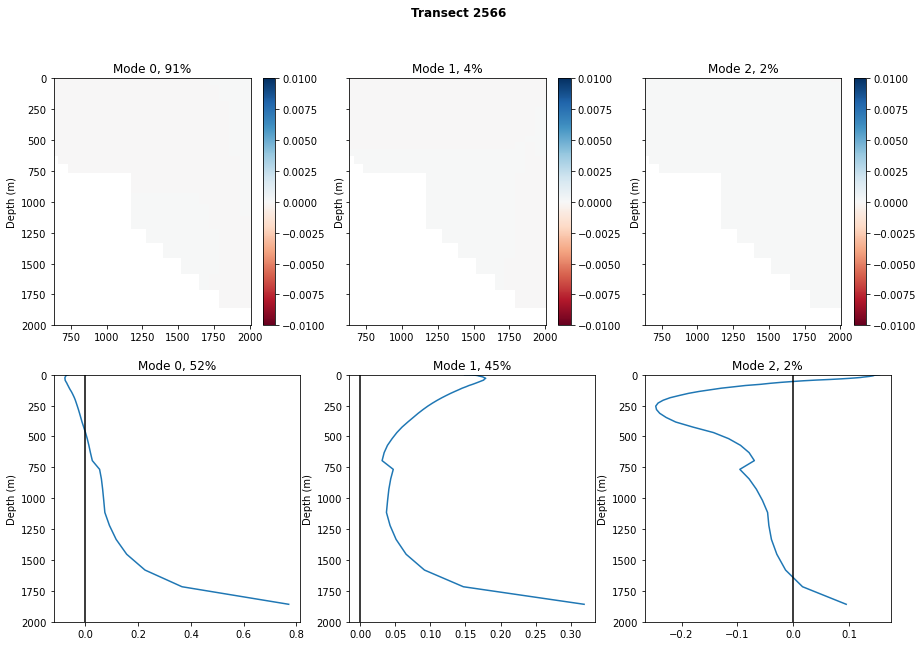

In [135]:
# Find transect that has barotropic mode 1:
index = np.argmin(mode_1_cs)-0
index
# Okay, looks like for this case mode 0 and mode 1 are swopped: mode 0 is baroclinic (91%) and mode 1 is barotropic (only 4%).
plot_eof(index)

Look into transects where first eof is bcl

In [44]:
# Transects that have a bcl first eof
index_cs = []
for ii in range(len(ds.lon_shelf)):
    if mode_0_cs[ii] == 1:
        index_cs.append(ii)

In [49]:
print('How many transects are baroclinic in first eof: ', len(index_cs))

How many transects are baroclinic in first eof:  225


In [26]:
# Percentage of bcl vs btr first eof for cross-slope averaged velocity
print(np.round(np.sum(mode_0_cs)/len(ds.lon_shelf)*100, 2), '%')

6.89 %


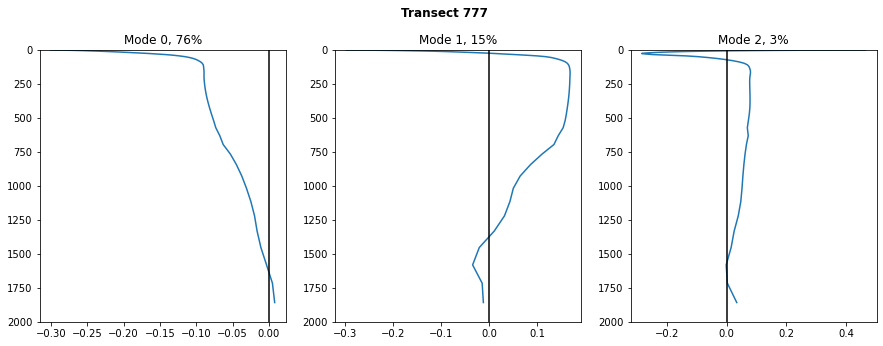

In [128]:
plot_eof_cs(index_cs[50])

---

---

(0.0, 300.0)

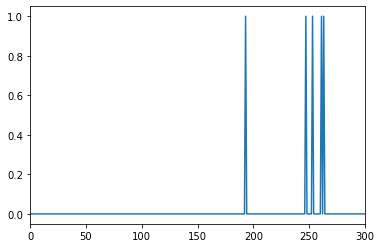

In [24]:
fig = plt.figure()

plt.plot(mode_0_cs)
plt.xlim(0, 300)

In [26]:
np.where(mode_0_cs!=0)

(array([193, 247, 253, 261, 263]),)

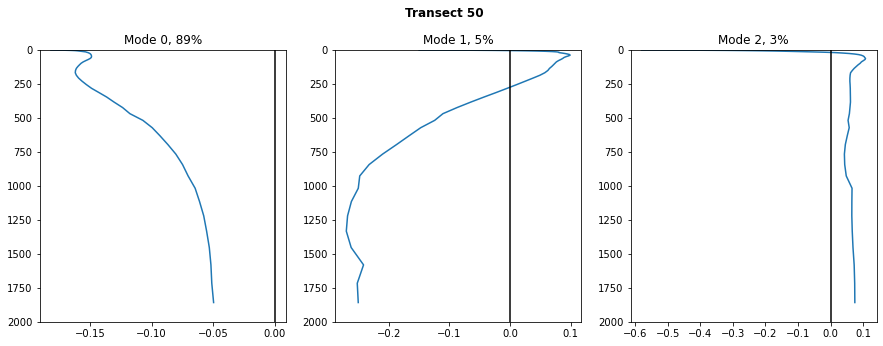

In [35]:
plot_eof_cs(50)

In [ ]:
# Example for 1 eof that looks barotropic, but has sign change: 263, 2566
# Example for 1 eof that is single sign, but doesn't look btr: 50

(-0.01, 0.3)

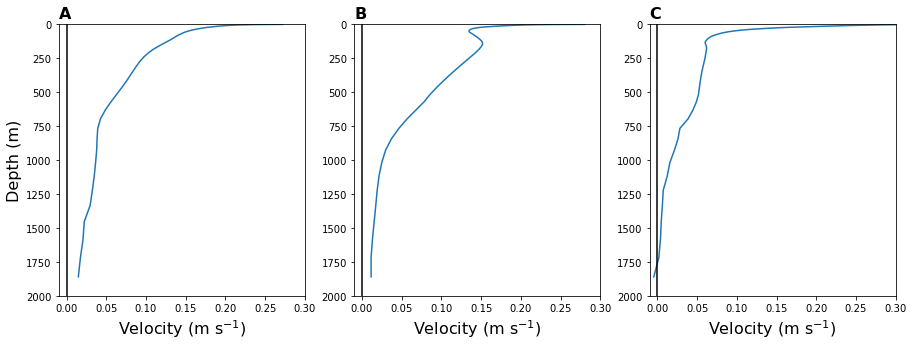

In [62]:
ft_size = 16

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
nn = 245
plt.plot(eof_field_cs[nn,0,:], eof_field_cs.st_ocean)#, cmap='RdBu', vmin=-0.01, vmax=0.01)
plt.ylim(2000, 0)
plt.axvline(0, color='k')
#plt.title(r'Transect %i'%nn, fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)
plt.xlabel('Velocity (m s$^{-1}$)', fontsize=ft_size)
plt.title('A', loc='left', fontweight='bold', fontsize=ft_size)
plt.xlim(-0.01, 0.3)

plt.subplot(1,3,2)
nn = 60
plt.plot(eof_field_cs[nn,0,:]*-1, eof_field_cs.st_ocean)#, cmap='RdBu', vmin=-0.01, vmax=0.01)
plt.ylim(2000, 0)
plt.axvline(0, color='k')
#plt.title(r'Transect %i'%nn, fontsize=ft_size)
plt.xlabel('Velocity (m s$^{-1}$)', fontsize=ft_size)
plt.title('B', loc='left', fontweight='bold', fontsize=ft_size)
plt.xlim(-0.01, 0.3)

plt.subplot(1,3,3)
nn = 263
plt.plot(eof_field_cs[nn,0,:], eof_field_cs.st_ocean)#, cmap='RdBu', vmin=-0.01, vmax=0.01)
plt.ylim(2000, 0)
plt.axvline(0, color='k')
#plt.title(r'Transect %i'%nn, fontsize=ft_size)
plt.xlabel('Velocity (m s$^{-1}$)', fontsize=ft_size)
plt.title('C', loc='left', fontweight='bold', fontsize=ft_size)
plt.xlim(-0.01, 0.3)